<a href="https://colab.research.google.com/github/AttiBae/BasicML/blob/main/Chapter4_MNIST_Classificationipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable as Variable
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import random

In [ ]:
MNIST_transform = transforms.Compose([transforms.Resize((28,28)),
                                   transforms.ToTensor()])

trainset = datasets.MNIST(root='./data/MNIST/', 
                           train=True,
                           download = True, 
                           transform=MNIST_transform)

testset = datasets.MNIST(root='./data/MNIST/', 
                           train=False, 
                           download = True, 
                           transform=MNIST_transform)

In [ ]:
train_loader = DataLoader(trainset, batch_size = 32, shuffle = True)
test_loader = DataLoader(testset, batch_size = 32, shuffle = True)

dataloaders = [train_loader, test_loader]

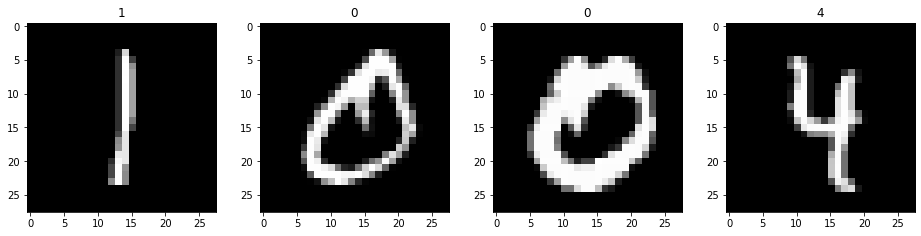

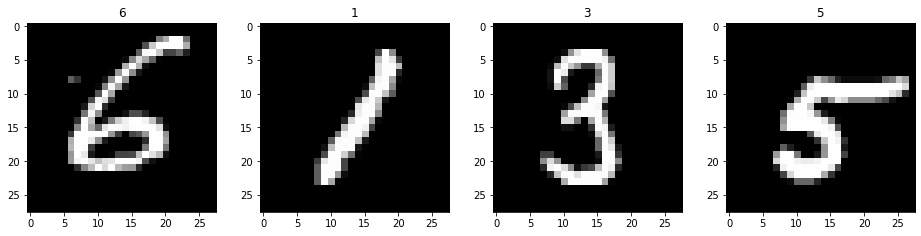

In [ ]:
image, label = next(iter(train_loader))

plt.figure(figsize=(16, 16))
for i in range(4):
    plt.subplot(4, 4, i+1)
    plt.imshow(image[i].squeeze(0), cmap='gray')
    plt.title(label[i].numpy())

image, label = next(iter(test_loader))

plt.figure(figsize=(16, 16))
for i in range(4):
    plt.subplot(4, 4, i+1)
    plt.imshow(image[i].squeeze(0), cmap='gray')
    plt.title(label[i].numpy())    

In [ ]:
class SimpleLayer(nn.Module):
    def __init__(self):
        super(SimpleLayer,self).__init__()
        self.fc1 = nn.Linear(28 * 28, 32)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        print(x.shape)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet,self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 32)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(1,16, kernel_size = 5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 5)
        self.fc1 = nn.Linear(32 * 4 * 4, 100)
        self.fc2 = nn.Linear(100, 32)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 32 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


#model = SimpleLayer()
#model = LinearNet()
model = ConvNet()

if torch.cuda.is_available():
  device = torch.device('cuda')
  model = model.to(device)
  is_cuda = 1
else: is_cuda = 0

In [ ]:
learning_rate = 0.001
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

num_epochs = 10

data_num = [len(trainset),len(testset)]

-----------------------------------
1 Epoch
train	Loss : 0.0066452 Acc : 93.367
test	Loss : 0.0019255 Acc : 97.96
-----------------------------------
2 Epoch
train	Loss : 0.0018755 Acc : 98.168
test	Loss : 0.0012624 Acc : 98.67
-----------------------------------
3 Epoch
train	Loss : 0.0012731 Acc : 98.703
test	Loss : 0.0011019 Acc : 98.93
-----------------------------------
4 Epoch
train	Loss : 0.00097211 Acc : 99.013
test	Loss : 0.00096862 Acc : 98.97
-----------------------------------
5 Epoch
train	Loss : 0.00075988 Acc : 99.273
test	Loss : 0.00104 Acc : 98.97
-----------------------------------
6 Epoch
train	Loss : 0.00061265 Acc : 99.37
test	Loss : 0.0010388 Acc : 98.97
-----------------------------------
7 Epoch
train	Loss : 0.00052168 Acc : 99.467
test	Loss : 0.00091171 Acc : 99.08
-----------------------------------
8 Epoch
train	Loss : 0.00040434 Acc : 99.582
test	Loss : 0.001164 Acc : 99.0
-----------------------------------
9 Epoch
train	Loss : 0.00037577 Acc : 99.575
test	

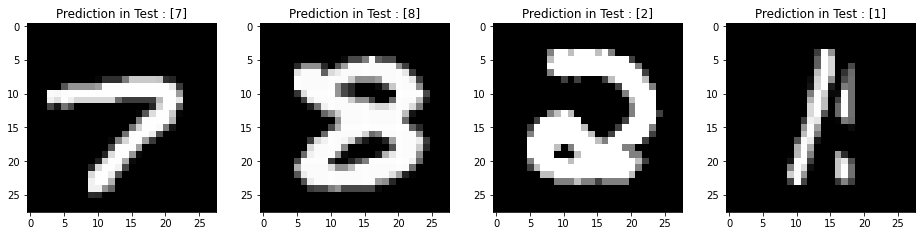

In [ ]:
start = time.time()
best_model = model.state_dict()
best_acc = 0.0

for epoch in range(num_epochs):
  print('-----------------------------------')
  print('{} Epoch'.format(epoch+1))

  for mode in ['train', 'test']:
    if mode == 'train':
      model.train(True)
      flag = 0
    else:
      model.train(False)
      flag = 1

    running_loss = 0.0  ## Loss & Acc Initialize
    running_corrects = 0

    for (data, target) in dataloaders[flag]:  ## Read Data from dataloaders
      if is_cuda:
        data, target = data.cuda(), target.cuda()
      data. target = Variable(data).to(device), Variable(target).to(device)  ## CUDA Setting

      optimizer.zero_grad()  ## Optimizer initialize every batch
      outputs = model(data)  ## Put images to network
      pred = outputs.data.max(dim=1, keepdim=True)[1]  ## prediction - MNIST data represented each 0 ~ 9
      loss = criterion(outputs, target)

      if mode == 'train':
        loss.backward()  ## get gradient
        optimizer.step()  ## optimizer task for network's train

      running_loss += loss.item()
      running_corrects += pred.eq(target.data.view_as(pred)).cpu().sum()

    epoch_loss = running_loss / data_num[flag]
    epoch_acc = running_corrects / data_num[flag] * 100  ## Accuracy (0~100%)
    print('{}\tLoss : {:.5} Acc : {:.5}'.format(mode, epoch_loss, epoch_acc))
    
    if mode == 'test' and epoch_acc > best_acc:  ## Store best-performed model data
      best_acc = epoch_acc
      best_model = model.state_dict()

 

elapsed_time = time.time() - start
print('Elapsed time : {}s'.format(elapsed_time))
plt.figure(figsize=(16, 16)) 
for i in range(4):
  plt.subplot(4, 4, i+1)
  plt.imshow(data[i].cpu().squeeze(0).numpy(), cmap='gray')
  plt.title('Prediction in Test : {}'.format(pred[i].cpu().numpy()))
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from glob import glob
import os

path = '/content/drive/MyDrive/BasicML/Chapter4/My_MNIST/'
files = glob(os.path.join(path, '*/*.jpg'))

print(f'Total # of images {len(files)}')

Total # of images 64


In [ ]:
MNIST_transform = transforms.Compose([transforms.Resize((28,28)),
                                   transforms.Grayscale(1),
                                   transforms.ToTensor()])

validset = datasets.ImageFolder(path, MNIST_transform)
valid_loader = DataLoader(validset, batch_size = 32, shuffle = True)

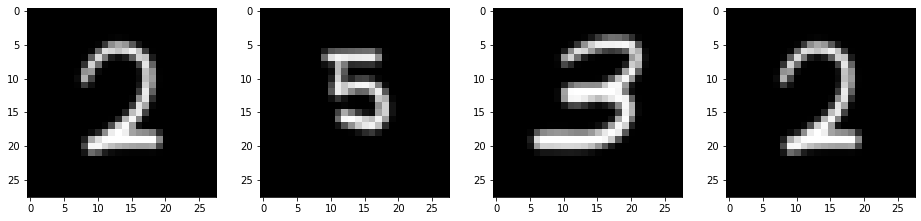

In [ ]:
image, label = next(iter(valid_loader))
plt.figure(figsize=(16, 16))
for i in range(4):
    plt.subplot(4, 4, i+1)
    plt.imshow(image[i,0,:,:], cmap='gray')

In [ ]:
model.load_state_dict(best_model)
model.eval()

ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=32, bias=True)
)

In [ ]:
for (data, _) in valid_loader:  ## Read Data
      if is_cuda:
        data = data.cuda()
      data = Variable(data).to(device) ## CUDA Setting

      outputs = model(data)  ## Put images to network
      pred = outputs.data.max(dim=1, keepdim=True)[1]  ## prediction

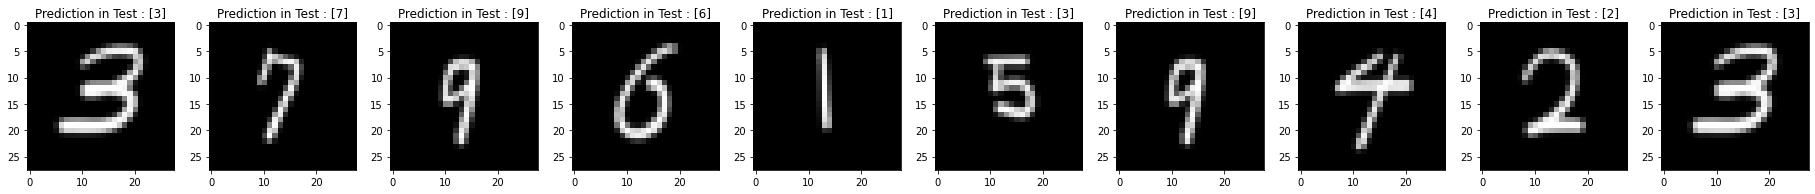

In [ ]:
plt.figure(figsize=(32, 32))  
for i in range(10):
  plt.subplot(10, 10, i+1)
  plt.imshow(data[i].cpu().numpy()[0], cmap='gray')
  plt.title('Prediction in Test : {}'.format(pred[i].cpu().numpy()))
plt.show()